In [43]:
import numpy as np
import matplotlib.pyplot as plt
import random
import agentpy as ap
from matplotlib import colors
from matplotlib.colors import ListedColormap
from datetime import datetime
import sys
from IPython import display

In [44]:
sys.setrecursionlimit(2000)


# basic square forest
# each cell has 3 possible states: 0, 1, 2 corresponding to empty, tree, fire
class square_forest:
	# ideally evolves till full destruction, but we can set a hard limit on time

	def __init__(self, dim):
		self.dim = dim  # dimension of square forest
		self.cells = np.zeros((self.dim, self.dim)) # forest grid init
		self.burnt = [] # not really a property, just easier to not pass this hehe; keeps track of how many trees were burnt and where in this forest instance
		self.grid_collector = [] # for the purpose of plotting

	def init_cells(self):
		# random init with some number of trees; upper limit = dim * dim
		n_max = np.random.randint(self.dim * self.dim) 

		loc_trees = set()
		for i in range(n_max):
			coords = tuple(np.random.randint(self.dim, size=2))
			loc_trees.add(coords)
			
		# planting trees
		for tree in loc_trees:
			# note here that the actual no. of trees in the init config is <= n_trees since the guessed locations need not be unique
			self.cells[tree[0], tree[1]] = 1

		# print(f"\nafter random tree planting: \n{self.cells}")
		self.grid_collector.append(self.cells.copy())
	
	def get_valid_neighbours(self, cell):
		# checking for edge indices 
		row, col = cell[0], cell[1]
		if row < 0 : 
			raise Exception("negative row index encountered")

		elif col < 0 : 
			raise Exception("negative column index encountered")

		elif row >= self.dim : 
			raise Exception("row index out of dimension bounds")

		elif col >= self.dim : 
			raise Exception("column index out of dimension bounds")

		else:
			# we're safe from unruly indices
			neighbours = [(row - 1, col), (row + 1, col), (row, col - 1), (row, col + 1)] # we're only interested in the adjacent cells according to the paper
			# print("\n -- adjacent cells indices are: ", neighbours)

			# marking useless neighbours i.e we only need cells with trees in the neighbourhood of interest
			for i, (r, c) in enumerate(neighbours):
				if r < 0 or c < 0 or r == self.dim or c == self.dim:
					neighbours[i] = None
				elif self.cells[r, c] != 1 :
					neighbours[i] = None

			# print("\n -- after None-ifying non tree cells and invalid edge cases: ", neighbours)

			# removing marked neighbour coords and appending only the valid ones
			valid_neighbours = []
			for n in neighbours:
				if n != None:
					valid_neighbours.append(n)

			# if len(valid_neighbours) != 0: print("\n List of valid neighbours: ", valid_neighbours) 

			return valid_neighbours

	
	def get_fire_loc(self):
		# randomly pick a fire location
		return np.random.randint(self.dim, size=2)

	
	def spread_to(self, valid_neighbours):
		# function to spread the fire to first degree neighbours; recursive
		# print("\n---------------------------\nThe next degree neighbours are at: ", valid_neighbours)
	
		# now we burn all of them:
		for (row, col) in valid_neighbours:
			# decimate: first set to 2
			self.cells[row, col] = 2
			self.burnt.append((row, col))
		
		self.grid_collector.append(self.cells.copy())

		# spread to second degree neighbours
		for cell in valid_neighbours:
			next_neighbours = self.get_valid_neighbours(cell)
			if len(next_neighbours) != 0: # i.e has somewhere to spread to
				self.spread_to(next_neighbours)

	
	def simulate_fire_at(self, fire_loc):
		# takes a location as a param, simulates the spread of fire at that location; keeps tabs on how much area has been affected

		self.cells[fire_loc[0], fire_loc[1]] = 2
		self.burnt.append(fire_loc)

		# spread
		neighbours = self.get_valid_neighbours(fire_loc)
		self.spread_to(neighbours)	# spread_to() will set the states to 2
		self.grid_collector.append(self.cells)

		# now we change it to 0 so that the simulation can proceed as required
		for (r, c) in self.burnt:
			self.cells[r, c] = 0

		area_burnt = len(self.burnt)
		self.burnt = [] # reset for next fire # if the locs themselves are not used, replace with a simple counter
		self.grid_collector.append(self.cells.copy())


		return area_burnt, self.grid_collector

	def plant_one_tree(self):
		# plants a NEW tree with probability 1 at a random location on the grid
		for i in range(self.dim * self.dim):
			coords = np.random.randint(self.dim, size=2)
			if self.cells[coords[0], coords[1]] != 1 : 
				
				# plant a tree since there is no tree here
				self.cells[coords[0], coords[1]] = 1 # planted
				self.grid_collector.append(self.cells.copy())
				break


## Initialize some forest

In [48]:
color_dict = {0.0:'wheat', 1.0:'yellowgreen', 2.0:'darkorange'}
color_lst = ['wheat','darkorange','yellowgreen']
cmap = colors.ListedColormap(color_lst)


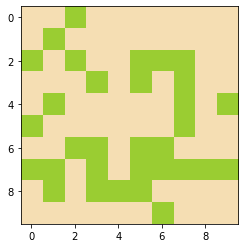

In [49]:
forest = square_forest(10)
forest.init_cells()
#plt.imshow(forest.cells)
plt.imshow(forest.cells, cmap=cmap)

In [50]:
for i in range(50):
    start_loc = forest.get_fire_loc()
    area_burnt, grids = forest.simulate_fire_at(start_loc)
    forest.plant_one_tree()

grids = forest.grid_collector

In [51]:
len(grids)

231

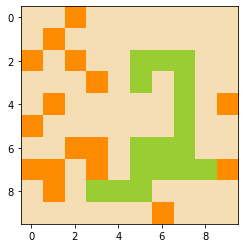

In [53]:
plt.imshow(grids[12], cmap=cmap)

## Plotting

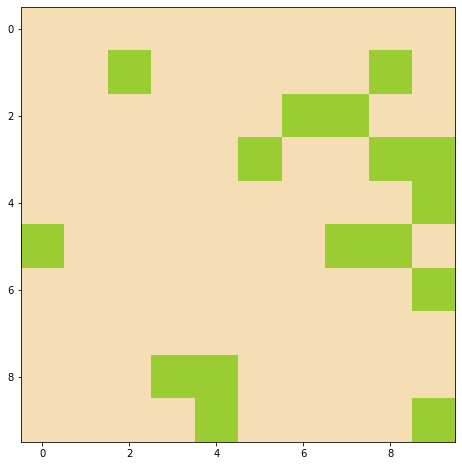

In [54]:
from PIL import Image
import matplotlib.animation as animation

#def animate_func(i):
    # animation function which is called sequentially
    #im.set_array(grids[i])
    #ax.set_title('Time step ' + str(i))
    #return im 

fps = 30
#nsec = 5

# set up the figure
fig, ax = plt.subplots(figsize=(8, 8))

# element to animate
#im = plt.imshow(grids[0])

frames=[]
for i in range(len(grids)):
    frames.append([plt.imshow(grids[i], cmap=cmap)])
    
anim = animation.ArtistAnimation(fig, frames)
#anim = animation.FuncAnimation(fig, animate_func)
anim.save('test_anim.mp4', fps=fps)
